# VGG16 model fine tuning using VGGFACE pretrained model <br>

Code inspired from keras tutorials: <br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html <br>
https://github.com/rcmalli/keras-vggface <br>
https://aboveintelligent.com/face-recognition-with-keras-and-opencv-2baf2a83b799 <br>
https://www.robots.ox.ac.uk/~vgg/software/vgg_face/  <br>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import copy
#import keras.backend.tensorflow_backend as K
import keras.backend as K
import tensorflow as tf
import os
from keras.models import model_from_yaml
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score
%matplotlib inline 

Using TensorFlow backend.


In [3]:
# VGGFace pretrainined model from VGGFace trained on VGG Face Dataset which has 2,622 identities. 
# http://www.robots.ox.ac.uk/~vgg/data/vgg_face/

model = VGGFace(model='vgg16')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [4]:
# Build our custom VGG16 model with the number of classes required for our project

number_of_classes = 56 # The number of student classes for our project
hidden_dim = 512 # The hidden dimension is basically the number of nodes in each layer

# create a vggface model
VGG16_Freeze_Top_Layers = VGGFace(include_top=False, input_shape=(224, 224, 3))
for layer in VGG16_Freeze_Top_Layers.layers:
    layer.trainable = False

# Changing the last few layers in the network to suit our requirements and to fine tune on our dataset later
last_layer = VGG16_Freeze_Top_Layers.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(number_of_classes, activation='softmax', name='softmax/activation')(x)
custom_model = Model(VGG16_Freeze_Top_Layers.input, out)

# Summay of the layers, shapes and params for our custom model
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [19]:
# Keras ImageDataGenerator used for image augmentation in real time for training set
# The data will be looped over (in batches)
# rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
# shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
# batch_size and shape of the target output of the ImageDataGenerator

batch_size = 16 # default: 32
height = 224
width = 224

# Generate batches of tensor image data with real-time data augmentation
train_data_dir = 'images/processed'
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(train_data_dir, # directory
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    class_mode='sparse') # One of "categorical", "binary", "sparse", "input", or None

Found 5121 images belonging to 56 classes.


In [20]:
# Keras ImageDataGenerator used for image augmentation in real time - validation set

test_data_dir = 'images/validation'
test_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  shuffle=False,
                                                  target_size=(height,width),
                                                  batch_size=batch_size,
                                                  class_mode='sparse') 

Found 560 images belonging to 56 classes.


In [7]:
# Class names extracted from our folder directory names
datasetDescriptor = 'images/processed'
class_names = os.listdir(datasetDescriptor)
print(class_names)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '36', '38', '4', '40', '42', '44', '46', '48', '5', '50', '52', '54', '56', '58', '6', '60', '7', '78', '8', '9', 'unknown 1', 'unknown 2', 'unknown 3', 'unknown 4', 'unknown 5', 'unknown 6', 'unknown 7', 'unknown 8']


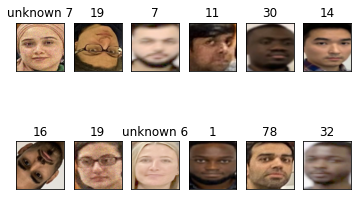

In [10]:
# Function to display image

def display(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im_color = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im_color = im_color.astype(np.uint8)
        plt.imshow(im_color)

batch_shape = (batch_size,custom_model.input_shape[1], 
                          custom_model.input_shape[2], 
                          custom_model.input_shape[3])
x = np.zeros(batch_shape)
y = np.zeros(batch_size)

# Display sample images from the training set ImageDataGenerator

x,y = train_generator.next()
images_number = 12        
for i in range(images_number):    
    plt.subplot(2,images_number/2,i+1)
    display(x[i,:,:,:])
    title = (class_names[int(y[i])])
    plt.title(title)
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

In [11]:
# ****                                   Transfer training                                         ****
# **** Fine tuning our custom model which is pretainined on VGGface dataset on our custom data set ****

# We tried two optimizers and find out Adam to be better one for our dataset.
# I also noted that with a smaller batch size. i get better accuracy results

#sgd = optimizers.SGD() # lr=0.1, decay=1e-6, momentum=0.9, nesterov=True
adam = optimizers.Adam()
custom_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

history = custom_model.fit_generator(train_generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=10,
                            validation_data=test_generator,
                            validation_steps=validation_steps,
                            max_queue_size=10, workers=2, 
                            use_multiprocessing=False)

Epoch 1/10
320/320 [==============================] - 4430s 14s/step - loss: 1.0184 - acc: 0.7609 - val_loss: 0.2507 - val_acc: 0.9411
Epoch 2/10
320/320 [==============================] - 3656s 11s/step - loss: 0.0449 - acc: 0.9906 - val_loss: 0.1383 - val_acc: 0.9589
Epoch 3/10
320/320 [==============================] - 3515s 11s/step - loss: 0.0128 - acc: 0.9977 - val_loss: 0.1117 - val_acc: 0.9696
Epoch 4/10
320/320 [==============================] - 3384s 11s/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9696
Epoch 5/10
320/320 [==============================] - 3385s 11s/step - loss: 4.4352e-04 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9750
Epoch 6/10
320/320 [==============================] - 3371s 11s/step - loss: 2.9775e-04 - acc: 1.0000 - val_loss: 0.0849 - val_acc: 0.9732
Epoch 7/10
320/320 [==============================] - 3373s 11s/step - loss: 2.1496e-04 - acc: 1.0000 - val_loss: 0.0828 - val_acc: 0.9732
Epoch 8/10
320/320 [=======================

In [64]:
# Keras registers callbacks when training a deep learning model. One of the default callbacks that is registered when training all deep learning models is the History callback. 
# It records training metrics for each epoch. This includes the loss and the accuracy for training and  validation dataset.

# list all data keys in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [12]:
# Mean accuracy for both dataset from the training history above.

acc_mean = np.mean(history.history['acc'])
val_acc_mean = np.mean(history.history['val_acc'])

print('The mean accuracy for the training set is %f.' %acc_mean)
print('The mean accuracy for the validation set is %f.' %val_acc_mean)

The mean accuracy for the training set is 0.974848.
The mean accuracy for the validation set is 0.968214.


In [21]:
# Classification Report

target_names = list(train_generator.class_indices.keys())

predicted = custom_model.predict_generator(test_generator, steps=validation_steps, verbose=1)
y_pred = np.argmax(predicted, axis=1)
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

35/35 [==============================] - 387s 11s/step

Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        10
          18       1.00      0.90      0.95        10
          19       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        10
          20       1.00      0.90      0.95        10
          21       1.00      0.70      0.82        10
          22       1.00      0.90      0.95        10
          23       0.83      1.00      0.91        10
  

In [33]:
# Confusion Matrix

cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]


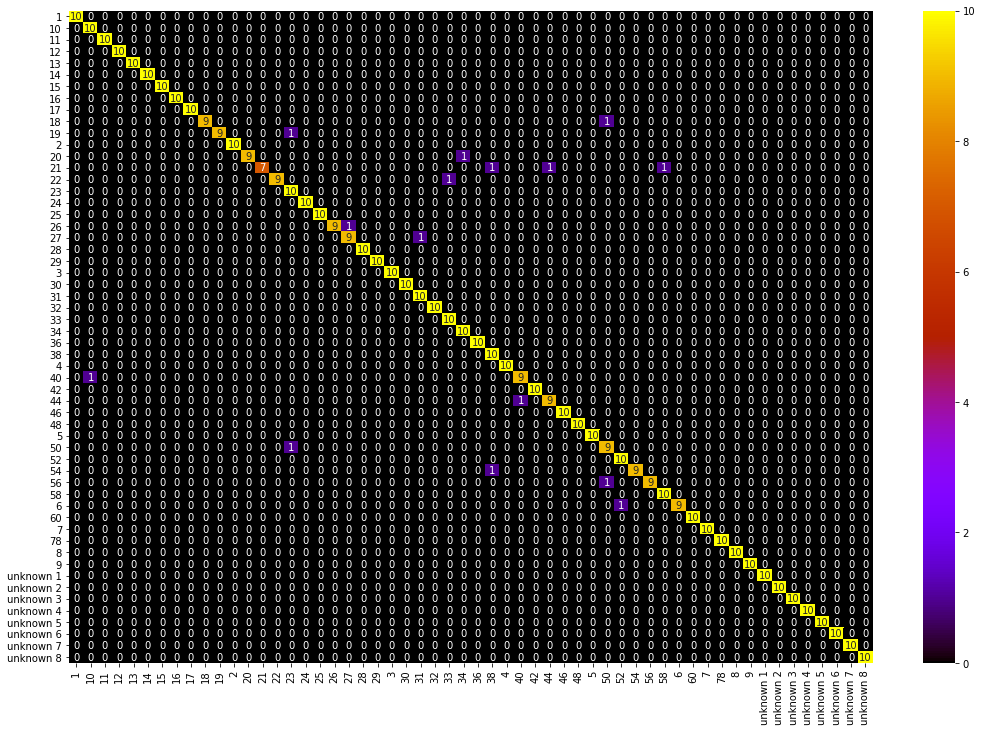

In [54]:
# Confusion Matrix display full with seaborn

import seaborn as sn
plt.figure(figsize = (18,12))
x_axis_labels = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '36', '38', '4', '40', '42', '44', '46', '48', '5', '50', '52', '54', '56', '58', '6', '60', '7', '78', '8', '9', 'unknown 1', 'unknown 2', 'unknown 3', 'unknown 4', 'unknown 5', 'unknown 6', 'unknown 7', 'unknown 8']
y_axis_labels = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '36', '38', '4', '40', '42', '44', '46', '48', '5', '50', '52', '54', '56', '58', '6', '60', '7', '78', '8', '9', 'unknown 1', 'unknown 2', 'unknown 3', 'unknown 4', 'unknown 5', 'unknown 6', 'unknown 7', 'unknown 8']

sn.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='gnuplot')

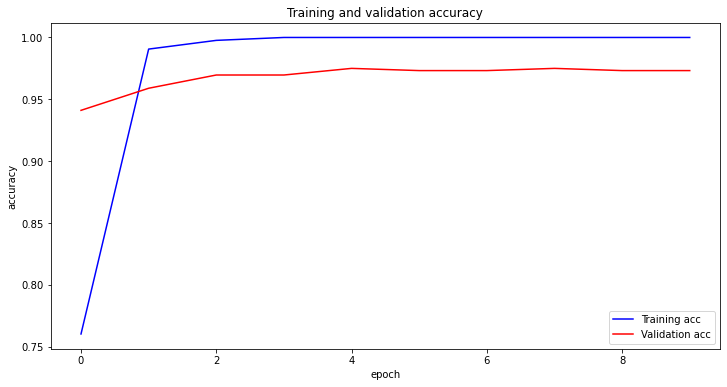

<Figure size 432x288 with 0 Axes>

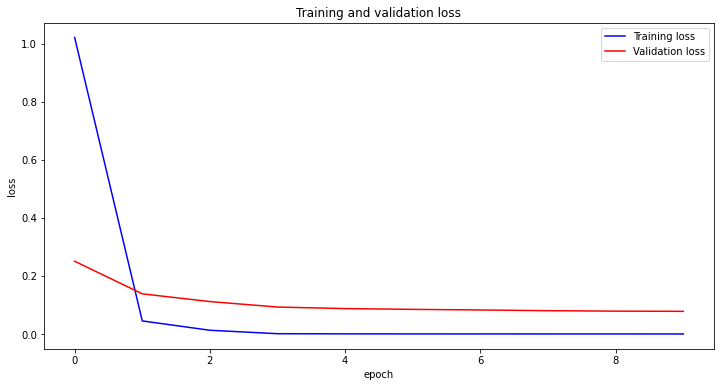

In [62]:
# Plotting accuracy and loss for both training and validation set from the history training generators

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12,6))
epochs = range(len(acc))

# Accuracy Plot
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

# Loss Plot
plt.figure()
plt.figure(figsize=(12,6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [59]:
# Model save for out custom VGG16 model

model_yaml = custom_model.to_yaml()
with open("models/modelVGG2.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
custom_model.save_weights("models/modelVGG2.h5")
print("Saved model to disk")

Saved model to disk


In [60]:
# Testing loading the model

yaml_file = open('models/modelVGG2.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("models/modelVGG2.h5")
print("Loaded model from disk")

C:\Users\Tareq\Anaconda3\envs\vision\lib\site-packages\keras\engine\saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


Loaded model from disk
